In [1]:
__nbid__ = '00XX'
__author__ = 'Stephanie Juneau <stephanie.juneau@noirlab.edu>, David Herrera <david.herrera@noirlab.edu>, and the Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20250803' # yyyymmdd
__datasets__ = ['desi_dr1','ls_dr10', 'sdss_dr17']
__keywords__ = ['extragalactic', 'galaxies', 'joint query', 'sparcl', 'spectra', 'spectroscopic redshift', '3d plot']

# Large Scale Structure Probed by the DESI and SDSS/BOSS Surveys
by Stéphanie Juneau, David Herrera, and the Astro Data Lab Team

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Query SDSS and DESI Spectroscopic Catalogs](#query)
* [Plot Results](#plots)
* [Retrieving spectra with SPARCL](#spectra)
* [Exercise](#exercise)
* [Large scale structure in 3D](3d_plot)
* [BONUS: multiple spectra for the same object](#bonusspectra)
* [BONUS: Large-Scale Structures with LS Morphologies](#morphology)
* [References](#references)


<a class="anchor" id="goals"></a>
# Goals
* Query SDSS and DESI spectroscopic catalogs
* Plot redshift distributions for both surveys to search for high-density peaks
* Plot on-sky position of extragalactic objects, color-coded by redshift
* Find and retrieve DESI spectra of galaxies in interesting structures
* Plot positions of galaxies in 3D (real space), and explore large scale structure interactively
* **Bonus:** Joint query between photometric (LS) and spectroscopic (SDSS) catalogs to explore galaxy morphologies across large scale structure

# Summary

In this Notebook, we explore large-scale structures of galaxies by combining spectroscopic redshifts from SDSS/BOSS with the newer Dark Energy Spectroscopic Instrument (DESI) survey. The latter has a much higher sampling and reaches higher redshifts thanks to targeting fainter objects. The advantage of spectroscopic redshifts is that they are far more accurate than photometric redshifts to probe distances to galaxies (though still need to be corrected for possible distortion effects, which we ignore here). 

For a given region of the sky, we investigate the redshift distribution of extragactic targets to identify possible high-density peaks that may trace large scale structures. We then plot the coordinates of the galaxies with a different color-coding for a small redshift slice that we wish to examine. The default region and redshift slides of interest include a galaxy group identified by DESI (Williams et al., in prep.) where we zoom in before retrieving the spectra with the Spectra Analysis and Retrievable Catalog Lab ([SPARCL](https://astrosparcl.datalab.noirlab.edu/)).

Then, we perform a new query of a larger region from DESI to be able to visualize and interact with a representation of these galaxies in the actual space. For that, we developed a 3D plot based on converting RA, DEC and z, into Cartesian coordinates as shown in the "Large scale structure in 3D" section.

The columns from the SDSS DR17 can be found here https://datalab.noirlab.edu/query.php?name=sdss_dr17.specobj

The columns from the DESI DR1 can be found here https://datalab.noirlab.edu/query.php?name=desi_dr1.zpix

#### Bonus sections

Below the main part of the notebook, there are two more advanced examples and an exercise for the reader. The first advanced example consists of finding and examing spectra for a location with multiple spectra for the same object. It uses SPARCL to find and retrieve spectra and zooms around spectral regions of interest. 

The second advanced example leverages the photometry from the DESI pre-imaging Legacy Survey (LS) for both the SDSS and DESI objects. We find that a simple figure of galaxy spatial locations color-coded by galaxy morphological type reveals the known morphology-density relation. On a technical point of view, this section illustrates an example joint query between the LS DR10 photometry Tractor table, and the SDSS/BOSS DR17 specObj spectroscopy table, and it is followed with suggestions for exercises for the reader.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binned_statistic_2d
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo
from astropy.convolution import convolve, Gaussian1DKernel
import plotly
import plotly.graph_objs as go
import pandas as pd
plotly.offline.init_notebook_mode()

# Data Lab
from dl import queryClient as qc
from dl import authClient as ac

# SPARCL
from sparcl.client import SparclClient

# Instantiate SPARCL client
client = SparclClient()

# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="query"></a>
# Query SDSS and DESI Spectroscopic Catalogs

The SDSS DR17 database is called **sdss_dr17** and includes several tables. We will use the **specobj** table, which has spectroscopic information.

The DESI DR1 database is called **desi_dr1** and also includes several tables. We will use the **zpix** table, which has spectroscopic information.

**Note:** The column names and descriptions can be found directly in a notebook with `qc.schema()` or from the [Data Lab Query Interface](https://datalab.noirlab.edu/query.php) or using the Table Access Protocol (TAP) service with a compatible tool such as TOPCAT.

### Query to SDSS DR17

In [4]:
# Define a region of interest: RA, Dec in degrees
ra_min = 183.5
ra_max = 187.
dec_min = 3.7
dec_max = 6.2

In [5]:
# sdss_dr17.specobj                          # SDSS DR17 specobj

# Write query statement (sql)
query = ("""
  SELECT S.specobjid as specobjid_dr17, S.z, S.ra as plug_ra, S.dec as plug_dec, S.class 
  FROM sdss_dr17.specobj AS S 
  WHERE S.z>0.001 AND S.ra BETWEEN %s AND %s AND S.dec BETWEEN %s AND %s  
  LIMIT 100000
  """) % (ra_min, ra_max, dec_min, dec_max)  # small region

# S.z                = redshift (z) from SDSS specObj table
# S.plug_ra, dec     = RA, Dec of SDSS fiber from specObj table
# S.class            = Source class (Star, Galaxy, QSO) from SDSS
#
# WHERE: requirement that RA & Dec coordinates are within a rectangular region
#        and extragalactic sources with z>0.001 cut

print(query)


  SELECT S.specobjid as specobjid_dr17, S.z, S.ra as plug_ra, S.dec as plug_dec, S.class 
  FROM sdss_dr17.specobj AS S 
  WHERE S.z>0.001 AND S.ra BETWEEN 183.5 AND 187.0 AND S.dec BETWEEN 3.7 AND 6.2  
  LIMIT 100000
  


In [6]:
# Call query client and save output as Astropy Table
result_sdss = qc.query(sql=query, fmt='table')

In [7]:
# Print length of table (Nb of rows) and the first 5 rows
print(len(result_sdss))
result_sdss[:5]

2787


<Table length=5>
   specobjid_dr17       z           plug_ra        plug_dec class 
       int64         float64        float64        float64   str6 
------------------- ---------- ------------------ --------- ------
 583304425838241792 0.76073253          183.51721 3.7385754    QSO
5346950154271610880  0.3083932 183.53804000000002 3.7992216 GALAXY
 949157575742482432  0.2146754          183.55875 3.7994271 GALAXY
5346948505004169216   4.579655          183.54098 3.9107778    QSO
 949157850620389376 0.07706329          183.53922 3.9280406 GALAXY

### Query DESI DR1 for the same region

In [8]:
# Write query statement (sql)
query_desi = (f"""
  SELECT Z.targetid, Z.mean_fiber_ra AS ra, Z.mean_fiber_dec AS dec, Z.spectype, Z.z, Z.zwarn, 
         P.morphtype, P.sersic, P.flux_r, P.flux_z
  FROM desi_dr1.zpix as Z
  LEFT JOIN desi_dr1.photometry as P
  ON Z.targetid = P.targetid
  WHERE z>0.001 AND mean_fiber_ra BETWEEN {ra_min} AND {ra_max} AND mean_fiber_dec BETWEEN {dec_min} AND {dec_max}  
  LIMIT 100000""")

print(query_desi)


  SELECT Z.targetid, Z.mean_fiber_ra AS ra, Z.mean_fiber_dec AS dec, Z.spectype, Z.z, Z.zwarn, 
         P.morphtype, P.sersic, P.flux_r, P.flux_z
  FROM desi_dr1.zpix as Z
  LEFT JOIN desi_dr1.photometry as P
  ON Z.targetid = P.targetid
  WHERE z>0.001 AND mean_fiber_ra BETWEEN 183.5 AND 187.0 AND mean_fiber_dec BETWEEN 3.7 AND 6.2  
  LIMIT 100000


In [9]:
# Call query client and save output as Astropy Table
result_desi = qc.query(sql=query_desi, fmt='table')

In [10]:
# Print length of table (Nb of rows) and the first 5 rows
print(len(result_desi))
result_desi[:5]

21567


<Table length=5>
     targetid             ra               dec        ...   flux_r    flux_z  
      int64            float64           float64      ...  float64   float64  
----------------- ----------------- ----------------- ... --------- ----------
39627878383485976  183.554441936813 3.702033373300728 ... 0.9289058   2.085258
39627878383486124 183.5631682758731 3.726832640815866 ... 0.5910189 0.96338916
39627878383485993 183.5558190423874 3.704750511041479 ... 0.5557158  1.0517178
39627878383485309 183.5221280503672 3.720478199083277 ... 1.9224975  1.8692778
39627878383485301 183.5218761661378 3.724556141139497 ... 2.3651907  3.0709994

<a class="anchor" id="plots"></a>
# Plot Results

## Start with redshift distribution to find overdensities

Above, you might have noticed that there are manu more DESI redshifts than SDSS redshifts in the same region of the sky! This is because the DESI survey has a much denser spectroscopic sampling. It also targets fainter objects in order to reach higher redshifts. Let's compare the redshift distributions.

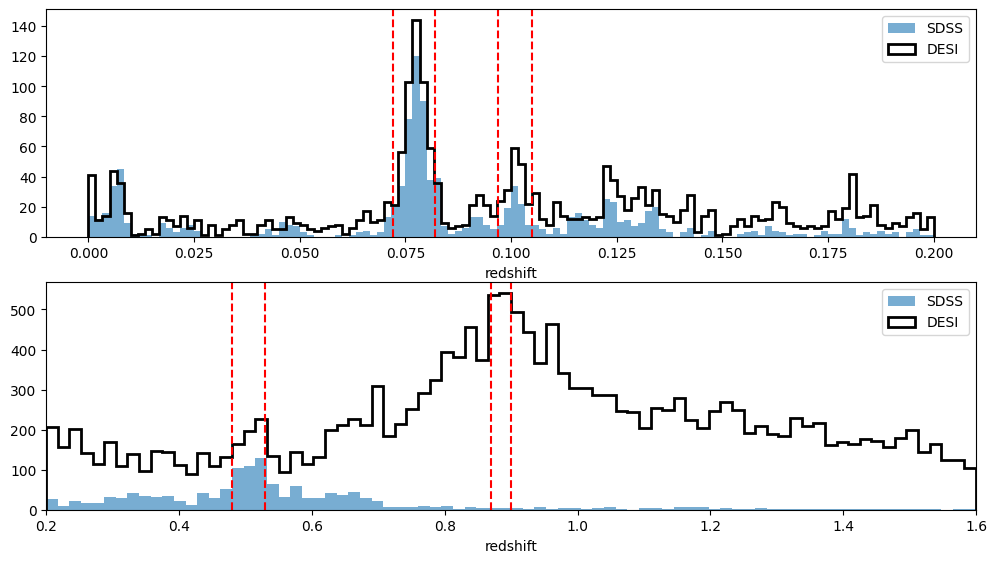

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6.5))
ax1.hist(result_sdss['z'], bins=120, range=(0,0.2), alpha=0.6, label='SDSS')
ax1.hist(result_desi['z'], bins=120, range=(0,0.2), histtype='step', color='k', lw=2, label='DESI')

# peak at z~0.077
ax1.axvline(0.072, color='r', ls='--')
ax1.axvline(0.082, color='r', ls='--')
# peak at z~0.1
ax1.axvline(0.097, color='r', ls='--')
ax1.axvline(0.105, color='r', ls='--')

# Legend and axis label
ax1.legend()
ax1.set_xlabel('redshift')

# Second panel to extend the redshift range
ax2.hist(result_sdss['z'], bins=80, range=(0.2,1.6), alpha=0.6, label='SDSS')
ax2.hist(result_desi['z'], bins=80, range=(0.2,1.6), histtype='step', color='k', lw=2, label='DESI')
ax2.set_xlim(0.2,1.6)
# highlight possible redshift peaks
ax2.axvline(0.48, color='r', ls='--')
ax2.axvline(0.53, color='r', ls='--')
ax2.axvline(0.87, color='r', ls='--')
ax2.axvline(0.9, color='r', ls='--')

# Legend and axis label
ax2.legend()
ax2.set_xlabel('redshift');

**NOTES:** Above, we see a few peaks that may correspond to large-scale structures / overdensities. We also see that DESI covers many more objects already starting at redshift z>0.1 and with an increasingly pronounced difference at z>0.6.

## Visual Inspection of Large-Scale Structures

Plot the positions of a broad range of redshift, and overplot a thin slice in redshift to show possible structures within that slice.

In [12]:
# Select redshift slice near peak at z~0.1
zmin = 0.097
zmax = 0.105

# Redshift range
rz = (result_sdss['z'] >zmin) & (result_sdss['z']<zmax)
rz_desi = (result_desi['z'] >zmin) & (result_desi['z']<zmax)

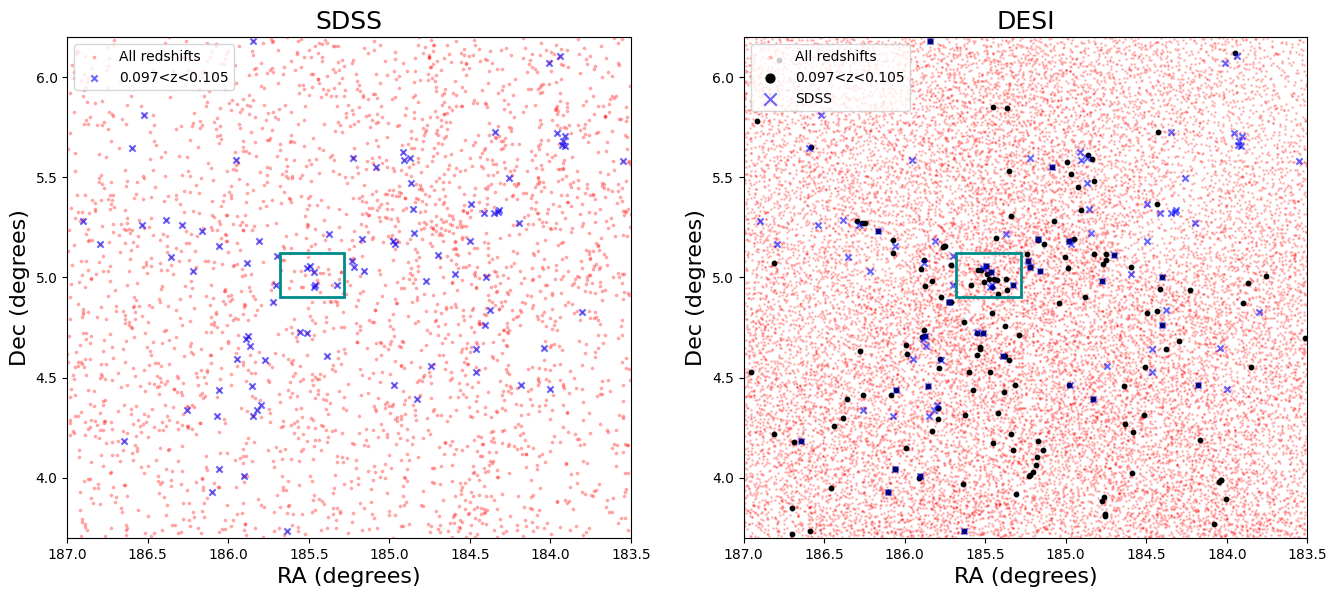

In [13]:
# Extent of RA, Dec (in degrees) to plot based on region queried above
xmin = ra_min
xmax = ra_max
ymin = dec_min
ymax = dec_max

# region of interest for Zooming in (here choosing a known DESI group; Williams et al. in prep.)
ra_reg = 185.48 # degrees
dec_reg = 5.01
# full width for rectangular region
dra_reg = 0.4
ddec_reg = 0.22

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6.5))

## SDSS Version

# plot all points in red (all redshifts)
ax1.scatter(result_sdss['plug_ra'],result_sdss['plug_dec'],s=3,color='r',marker='o',alpha=0.25, label='All redshifts')

# overplot in blue objects in narrow redshift slice
ax1.scatter(result_sdss['plug_ra'][rz],result_sdss['plug_dec'][rz],s=20,color='b',marker='x', alpha=0.6, label='0.097<z<0.105')
ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=16)
ax1.set_ylabel("Dec (degrees)", fontsize=16)
ax1.legend()

# add rectangle to show where we zoom in next panel (input lower corner and sizes)
ax1.add_patch(patches.Rectangle((ra_reg-dra_reg/2., dec_reg-ddec_reg/2.), dra_reg, ddec_reg,fill=False,color='darkcyan',lw=2))


## DESI Version

# plot all points in red (all redshifts)
ax2.scatter(result_desi['ra'],result_desi['dec'],s=1,color='r',marker='o',alpha=0.2, label='All redshifts')

# overplot in black DESI objects in narrow redshift slice
ax2.scatter(result_desi['ra'][rz_desi],result_desi['dec'][rz_desi],s=10,color='k',marker='o', label='0.097<z<0.105')

# Add SDSS locations in the same redshift slice
ax2.scatter(result_sdss['plug_ra'][rz],result_sdss['plug_dec'][rz],s=20,color='b',marker='x', alpha=0.6, label='SDSS')
ax2.axis([xmin, xmax, ymin, ymax])
ax2.set_xlim(reversed(ax2.set_xlim())) # flip the x-axis
ax2.set_xlabel("RA (degrees)", fontsize=16)
ax2.set_ylabel("Dec (degrees)", fontsize=16)

# add rectangle to show where we zoom in next panel
ax2.add_patch(patches.Rectangle((ra_reg-dra_reg/2., dec_reg-ddec_reg/2.), dra_reg, ddec_reg,fill=False,color='darkcyan',lw=2))
ax2.legend(loc='upper left', markerscale=2)

ax1.set_title('SDSS', fontsize=18)
ax2.set_title('DESI', fontsize=18)

plt.show()

Above, the left-hand panel shows a thin redshift slice (0.097 < *z* < 0.105, blue crosses) among objects with redshifts from the spectroscopic SDSS DR17 sample (red symbols). We can see by eye some large-scale filamentary structures and overdensities. The right-hand panel shows the same region but with all DESI redshifts (red dots). The same redshift slice at 0.097 < *z* < 0.105 is highlighted for both DESI (black circles) and SDSS (blue crosses, which are the same as on the left-hand panel). Together, we can see even more large scale structure including a newly revealed filament at the bottom center of the field of view.

The rectangle shows a selected region where we zoom in below to display color images.

## Zooming around a Galaxy Group

In [14]:
# Group from DESI Group catalog (Ian Williams et al., in prep.): Central from SDSS + Satellites from DESI

# Satellites
tids_group = [39627908548923781, 39627908548923981, 39627908548924068, 39627908548923268]
is_group = np.isin(result_desi['targetid'], tids_group)

result_desi[is_group]

<Table length=4>
     targetid             ra               dec        ...   flux_r    flux_z 
      int64            float64           float64      ...  float64   float64 
----------------- ----------------- ----------------- ... --------- ---------
39627908548923268 185.4551468300303  4.95269228493884 ... 15.544425 27.057499
39627908548923781 185.4789245609629 4.989838760307712 ... 63.448917  112.8158
39627908548923981 185.4900113037698 5.014922069179118 ... 26.913872 41.080944
39627908548924068 185.4951977488342 5.056336895846402 ... 101.35732 183.63795

In [15]:
# Central only has a SDSS spectrum
ra_central = 185.4596
dec_central = 4.9611
is_central = (abs(result_sdss['plug_ra']-ra_central)<1./3600)&(abs(result_sdss['plug_dec']-dec_central)<1./3600)

result_sdss[is_central]

<Table length=1>
   specobjid_dr17       z           plug_ra        plug_dec class 
       int64         float64        float64        float64   str6 
------------------- ---------- ------------------ --------- ------
5440360539787384832 0.10152001 185.45970999999997 4.9611619 GALAXY

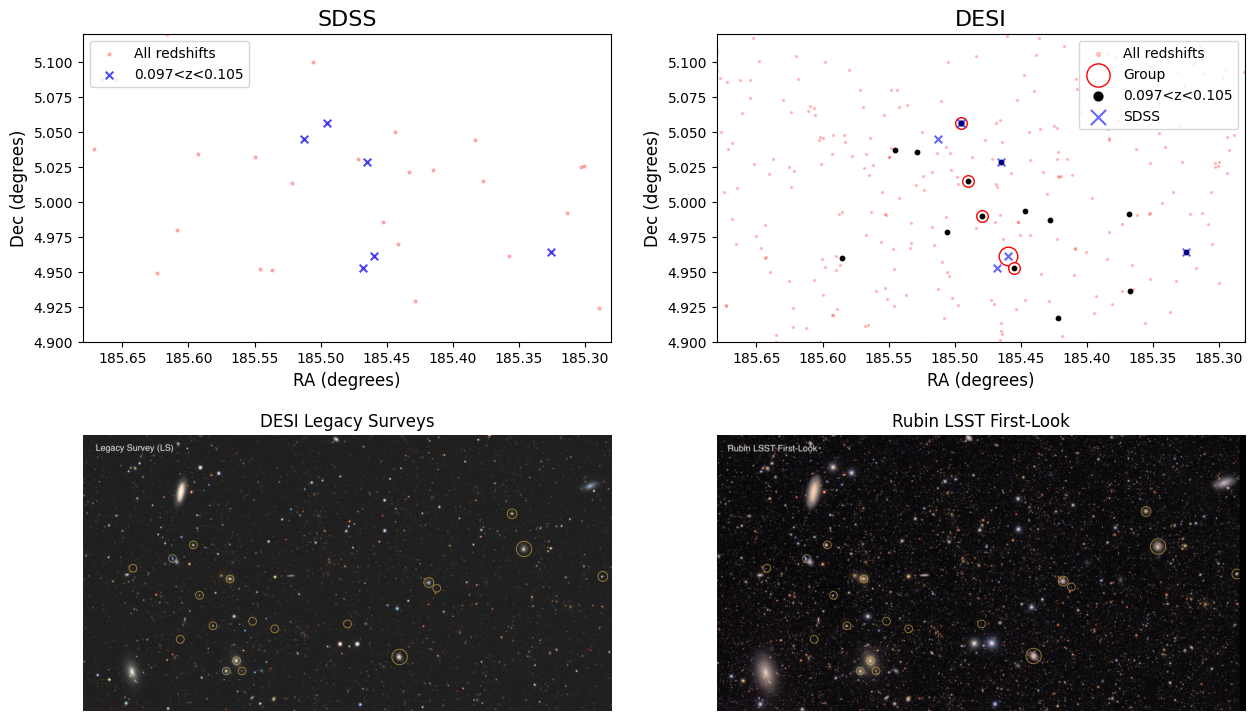

In [16]:
## ZOOM IN OVER THE SMALLER SELECTED REGION
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
plt.subplots_adjust(hspace=0.25, wspace=0.2)

# Extent of RA, Dec (in degrees) for smaller region "_reg"
xmin_reg = ra_reg - dra_reg/2.
xmax_reg = ra_reg + dra_reg/2.
ymin_reg = dec_reg - ddec_reg/2.
ymax_reg = dec_reg + ddec_reg/2.


## SDSS Version

# plot all points in red (all redshifts)
ax1.scatter(result_sdss['plug_ra'],result_sdss['plug_dec'],s=4,color='r',marker='o',alpha=0.25, label='All redshifts')

# overplot in blue objects in narrow redshift slice
ax1.scatter(result_sdss['plug_ra'][rz],result_sdss['plug_dec'][rz],s=30,color='b',marker='x', alpha=0.7, label='0.097<z<0.105')
ax1.axis([xmin_reg, xmax_reg, ymin_reg, ymax_reg])

# Define axis properties and legend
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=12)
ax1.set_ylabel("Dec (degrees)", fontsize=12)
ax1.legend(loc='upper left')


## DESI Version

# plot all points in red (all redshifts)
ax2.scatter(result_desi['ra'],result_desi['dec'],s=2,color='r',marker='o',alpha=0.2, label='All redshifts')

# Add the group including Satellites and Central galaxies
ax2.scatter(result_sdss['plug_ra'][is_central],result_sdss['plug_dec'][is_central],s=180,color='r',marker='o', facecolor='w')
ax2.scatter(result_desi['ra'][is_group],result_desi['dec'][is_group],s=70,color='r',marker='o', facecolor='w', label='Group')

# overplot in black DESI objects in narrow redshift slice
ax2.scatter(result_desi['ra'][rz_desi],result_desi['dec'][rz_desi],s=10,color='k',marker='o', label='0.097<z<0.105')

# Add SDSS locations in the same redshift slice
ax2.scatter(result_sdss['plug_ra'][rz],result_sdss['plug_dec'][rz],s=30,color='b',marker='x', alpha=0.6, label='SDSS')

# Define axis properties and legend
ax2.axis([xmin_reg, xmax_reg, ymin_reg, ymax_reg])
ax2.set_xlim(reversed(ax2.set_xlim())) # flip the x-axis
ax2.set_xlabel("RA (degrees)", fontsize=12)
ax2.set_ylabel("Dec (degrees)", fontsize=12)
ax2.legend(loc='upper right', markerscale=2)

# Titles
ax1.set_title('SDSS', fontsize=16)
ax2.set_title('DESI', fontsize=16)


## SHOW LS IMAGE (screenshot pre-made but could instead implement image cutout)
im = plt.imread('LS_view_LSS.jpg')
ax3.imshow(im)
ax3.axis('off')
ax3.set_title('DESI Legacy Surveys')

## Rubin LSST First-Look image from their Sky Viewer
im = plt.imread('Rubin_view_LSS.jpg')
ax4.imshow(im)
ax4.axis('off')
ax4.set_title('Rubin LSST First-Look')

plt.show()

In [17]:
t1 = Table()
is_reg_D = (result_desi['ra']>xmin_reg)&(result_desi['ra']<xmax_reg)&(result_desi['dec']>ymin_reg)&(result_desi['dec']<ymax_reg)
t1 = result_desi['ra','dec'][rz_desi&is_reg_D]
#t1 = result_desi['ra','dec','targetid'][rz_desi&is_reg_D]
t1['NAME'] = ''
t1['color'] = 'yellow'

t2 = Table()
is_reg = (result_sdss['plug_ra']>xmin_reg)&(result_sdss['plug_ra']<xmax_reg)&(result_sdss['plug_dec']>ymin_reg)&(result_sdss['plug_dec']<ymax_reg)
t2 = result_sdss['plug_ra', 'plug_dec'][rz&is_reg]
#t2 = result_sdss['plug_ra', 'plug_dec', 'specobjid_dr17'][rz&is_reg]
t2['NAME'] = ''
t2['color'] = 'cyan'

#t1.rename_column('targetid','NAME')
#t2.rename_column('specobjid_dr17' ,'NAME')

t1.rename_column('ra','RA')
t2.rename_column('plug_ra' ,'RA')

t1.rename_column('dec','DEC')
t2.rename_column('plug_dec' ,'DEC')


from astropy.table import vstack

t = vstack([t2, t1])

outfile = 't_sdss_desi.fits'
t.write(outfile, overwrite=True)

print("Region coordinates ")
print("RA:  ", xmin_reg, xmax_reg)
print("Dec: ", ymin_reg, ymax_reg)

Region coordinates 
RA:   185.28 185.67999999999998
Dec:  4.8999999999999995 5.12


All panels show the small region enclosed in the rectangle that we chose above. The top left for SDSS only, the top right for DESI with the selected redshift slice including both DESI and SDSS. The bottom panels are color images of the same region of the sky from the [LS sky viewer](https://legacysurvey.org/viewer?ra=128.7040&dec=8.8439&zoom=13&layer=ls-dr10). The galaxies encircled correspond to the points in black circles and blue crosses, which may belong to groups and filaments.

#### Double-click this cell and uncomment the following to display an animated version of the image comparison
<figure>
<img src="LS_vs_LSST.gif", align="left", width=900>
</figure>

<a class="anchor" id="spectra"></a>
# Retrieving spectra with SPARCL

Next, we find the spectra available in SPARCL from SDSS and from DESI for the small region and redshift slice of interest.

In [18]:
# Define the fields we want returned (`outfields`) and the constraints (`constraints`)
out = ['sparcl_id', 'ra', 'dec', 'redshift', 'spectype', 'specprimary']
cons = {'redshift': [zmin, zmax],
        'ra': [xmin_reg, xmax_reg],
        'dec': [ymin_reg, ymax_reg],
        'specprimary': [True],
        'data_release': ['DESI-DR1', 'SDSS-DR16', 'BOSS-DR16']}

In [19]:
# Execute the `client.find()` method with our parameters
found = client.find(outfields=out, constraints=cons, limit=100)

In [20]:
# How many records were found
print(found.count)

22


In [21]:
# Convert to pandas DataFrame
df = pd.json_normalize(found.records)
df[:2]

spectype  specprimary       dec  redshift          ra  \
0   GALAXY         True  4.961162  0.101520  185.459710   
1   GALAXY         True  4.917056  0.101929  185.422018   

                              sparcl_id        _dr  
0  36dfbe25-a07c-11ee-8509-525400ad1336  BOSS-DR16  
1  3f70f4af-8899-11ef-8a3e-525400f334e1   DESI-DR1

### Use the sparcl_ids from the output of using `client.find()` to retrieve records from SPARCL

In [22]:
# Define the fields to include in the retrieve function
inc = ['specid', 'ra', 'dec', 'redshift', 'wavelength', 'flux', 'ivar', 'spectype', 'data_release', 'dateobs_center']

In [23]:
# Execute client.retrieve to obtain the spectra for the list of id's
ids_I = found.ids
results = client.retrieve(uuid_list=ids_I, include=inc)
results.info

{'status': {'success': True,
  'info': ["Successfully found 22 records in dr_list={'DESI-EDR', 'DESI-DR1', 'SDSS-DR16', 'BOSS-DR16'}"],
  'warnings': []}}

In [24]:
# Convert the spectra to pandas DataFrame
df_spec = pd.json_normalize(results.records)

In [25]:
df_spec[:2]

dec          ra data_release               specid spectype  redshift  \
0  4.961162  185.459710    BOSS-DR16  5440360539787382784   GALAXY  0.101520   
1  4.917056  185.422018     DESI-DR1     2715104181223427   GALAXY  0.101929   

                                                flux  \
0  [-59.889915466308594, -59.87464904785156, -36....   
1  [-1.2821931838989258, -2.5931313037872314, 1.4...   

                                          wavelength  \
0  [3556.3131856898544, 3557.1321513458824, 3557....   
1  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                ivar  \
0  [0.0, 0.03543780744075775, 0.0, 0.035416152328...   
1  [0.16010639071464539, 0.12268313765525818, 0.1...   

                  dateobs_center        _dr  
0         2011-04-29 04:31:02+00  BOSS-DR16  
1  2022-04-21 17:23:30.718608+00   DESI-DR1

In [26]:
is_desi = df_spec['data_release']=='DESI-DR1'
is_sdss = (df_spec['data_release']=='SDSS-DR16')|(df_spec['data_release']=='BOSS-DR16')

print(f'N(SDSS) = {len(df_spec[is_sdss])}')
print(f'N(DESI) = {len(df_spec[is_desi])}')

N(SDSS) = 6
N(DESI) = 16


### Example 1: central and satellite galaxies from a DESI group

In [27]:
# Define central and group criteria for the new df_spec dataframe
is_central_spec = (abs(df_spec['ra']-ra_central)<1./3600)&(abs(df_spec['dec']-dec_central)<1./3600)
is_group_spec = np.isin(df_spec['specid'], tids_group)

# SDSS spectrum for central in rest-frame
z_central = df_spec['redshift'][is_central_spec].iloc[0]
wl_central = df_spec[is_central_spec].iloc[0].wavelength/(1.+z_central)
flux_central = df_spec[is_central_spec].iloc[0].flux*(1.+z_central)
ivar_central = df_spec[is_central_spec].iloc[0].ivar/(1.+z_central)**2


Text(0.5, 0, 'Wavelength [Angstrom]')

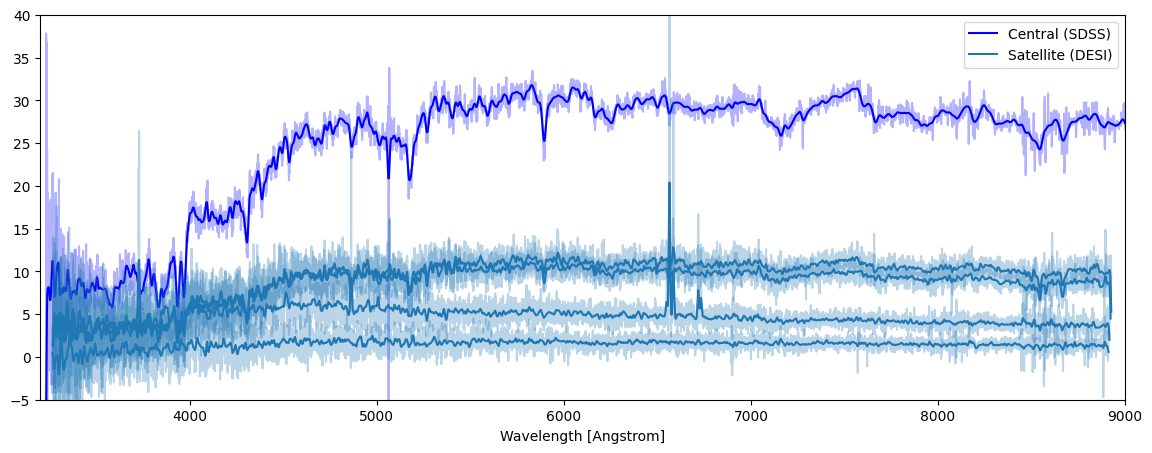

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(14,5))

# Plot spectrum of central galaxy
ax.plot(wl_central, flux_central, color='b', alpha=0.3)
# Overplot smoothed spectrum of central galaxy
ax.plot(wl_central, convolve(flux_central, Gaussian1DKernel(5)), color='b', label='Central (SDSS)')

for i in range(len(df_spec[is_group_spec])):
    z_group = df_spec['redshift'][is_group_spec].iloc[i]
    wl_group = df_spec[is_group_spec].iloc[i].wavelength/(1.+z_group)
    flux_group = df_spec[is_group_spec].iloc[i].flux*(1.+z_group)
    ivar_group = df_spec[is_group_spec].iloc[i].ivar/(1.+z_group)**2

    wl = wl_group[ivar_group!=0]
    flux = flux_group[ivar_group!=0]
    
    # Plot spectra of satellites (group members from DESI, which does not include the central)
    ax.plot(wl, flux, color='tab:blue', alpha=0.3)

    # Overplot spectrum smoothed using a 1-D Gaussian Kernel
    if i==0:
        ax.plot(wl, convolve(flux, Gaussian1DKernel(5)), color='tab:blue', label='Satellite (DESI)')
    else:
        ax.plot(wl, convolve(flux, Gaussian1DKernel(5)), color='tab:blue')


ax.legend()
ax.set_xlim(3200, 9000)
ax.set_ylim(-5,40)

# add axis label
ax.set_xlabel('Wavelength [Angstrom]')

### Example 2: multiple spectra for the same object

For an additional example, see the section "BONUS: multiple spectra for the same object" toward the end of the notebook, which uses the same dataframe `df_spec` above.

<a class="anchor" id="3d_plot"></a>
# Large scale structure in 3D

We can explore filaments and clusters of galaxies better if we can plot them in 3D. We turn to a different area of the sky, and will query for a sample of SDSS galaxies in the near to slightly distant universe, and plot in 3D the cone containing them. To avoid conamination by the galactic plane of the Milky Way, we point our search cone at high galactic latitudes.

### Data query and preparation
We select (mostly) SDSS galaxies within a 10-degree radius around a high galactic latitude direction, (ra,dec) = (160,45) degrees. We limit our search to positive redshifts between 0.02 and 0.3.

In [ ]:
# Create the query to fetch the SDSS data from Data Lab:

query = """
SELECT ra,dec,z
FROM sdss_dr17.specobj
WHERE q3c_radial_query(ra,dec,%s,%s,%s)
AND z between 0.02 AND 0.3
""" % (160,45,10)

print (query)

Run the query to fetch the SDSS data from the `ls_dr17.specobj` table

In [ ]:
selection = qc.query(adql=query, fmt='csv')

Reformat output into a table

In [ ]:
data = Table.read(selection, format='csv')  #Astropy Table
print("Number of galaxies in the sample: %d" % len(data))
data[:5]

Compute luminosity distance for every galaxy, using [Planck2018 cosmology](https://ui.adsabs.harvard.edu/abs/2020A%26A...641A...6P/abstract) values

In [ ]:
dist = cosmo.luminosity_distance(data['z'])
dist

To plot the positions of each galaxy in true 3D space, we will convert the angular coordinates ra & dec, and the distance coordinate, to Cartesian coordinates X,Y,Z (all measured in Mpc from the coordinate system origin).

In [ ]:
def get_cartesian(ra,dec,dist):
    # convert ra and dec to radians, since numpy expects this as arguments to trigonometric functions
    rarad = np.radians(ra)
    decrad = np.radians(dec)
    X = dist * np.sin(decrad) * np.cos(rarad)
    Y = dist * np.sin(decrad) * np.sin(rarad)
    Z = dist * np.cos(decrad)
    return X,Y,Z

In [ ]:
X,Y,Z = get_cartesian(data['ra'],data['dec'],dist)

### Plotting in 3D
To create an interactive 3D plot (one where we can zoom, pan, and rotate the scene), we will use the plotly package. The galaxies in our sample will be plotted using a 3D scatter routine. We also set some overall properties of the plot, such as the size of the markers, and a color map (we color each galaxy redder the further away it is).

In [ ]:
trace = go.Scatter3d(
    x = X,
    y = Y,
    z = Z,
    mode = 'markers',
    marker = {
        'size'      : 0.7,
        'opacity'   : 0.5,
        'color'     : dist, 
        'colorscale': 'OrRd'
    }
)

data = [trace]

Next, we define camera location and the layout of the plot

In [ ]:
# set up the view point
camera = dict(
    up = dict(x = 0, y = 0, z = 1),
    center = dict(x = 0.2, y = 0, z = 0),
    eye = dict(x = 0.6, y = -0.6, z = -1.0)
)

# set up the plot scene
layout = go.Layout(
    scene = dict(
        xaxis = dict(title = 'X',
                     backgroundcolor = 'black',
                     gridcolor = "rgb(40,40,40)"),
        yaxis = dict(title = 'Y',
                     backgroundcolor = 'black',
                     gridcolor = "rgb(40,40,40)"),
        zaxis = dict(title = 'Z',
                     backgroundcolor = 'black',
                     gridcolor = "rgb(40,40,40)"),
    ),
        scene_camera = camera,
        plot_bgcolor = 'black',
        paper_bgcolor = 'black',
        title = None,
        showlegend = False,
        width = 800,
        height = 800,
        autosize = False,
        margin = {'l':0, 'r':0, 'b':0, 't':0},
        dragmode = 'orbit'
)

In [ ]:
# Draw the plot
plot_figure = go.Figure(data=data, layout=layout)
plot_figure.update_layout()

Explore the scene by:
- **Zooming in and out** (mouse scroll wheel up/down, or click mouse middle button and move mouse up/down, or select "zoom" mode via button in upper-right corner & left-click + drag mouse)
- **Panning left/right and up/down** (click mouse left button and drag)
- **Change pan/rotate mode** by selecting one of the buttons in the upper-right corner of the plot (pan, orbital rotation, turntable rotation)

Observe how the galaxies form compact groups and clusters, and on larger scales form huge filaments. This is the large scale structure of the universe. In details, we can also notice some elongation along the direction of redshift due to [redshift space distortions](https://en.wikipedia.org/wiki/Redshift-space_distortions). 

---

<a class="anchor" id="bonusspectra"></a>
## BONUS: multiple spectra for the same object

Some objects have been observed with both SDSS/BOSS and with DESI so there can be multiple spectra for the same object. Furthermore, the DESI spectra are split per `survey` (sv1, sv2, sv3, main, special) and `program` (dark, bright, backup) so there can be multiple DESI spectra for the same object with a given `targetid`. Lastly, there is another special case in DESI due to some secondary targets being selected from non-DESI photometry and therefore receiving a distinct `targetid`.

In [29]:
# Location identified as having multiple spectra -- let's check
has_multiple = (df_spec['ra']>185.45)&(df_spec['ra']<185.5)&(df_spec['dec']>5.05)&(df_spec['dec']<5.06)

df_spec[has_multiple]

dec         ra data_release               specid spectype  redshift  \
5   5.056335  185.49521    SDSS-DR16  3242699284616865792   GALAXY  0.100523   
11  5.056343  185.49519     DESI-DR1     2842647530045447   GALAXY  0.100641   
16  5.056343  185.49519     DESI-DR1    39627908548924068   GALAXY  0.100587   

                                                 flux  \
5   [4.138749122619629, 4.137338161468506, 4.13592...   
11  [2.3694067001342773, -1.429848551750183, 6.022...   
16  [-1.3158117532730103, -0.1880265325307846, 3.2...   

                                           wavelength  \
5   [3805.397250027089, 3806.2735760120595, 3807.1...   
11  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
16  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                 ivar  \
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
11  [0.12570221722126007, 0.10522054880857468, 0.1...   
16  [0.0369296632707119, 0.0339537039399147, 0.034...   

                   dateobs_center        _dr  
5          2008-02-13 00:00:00+00  SDSS-DR16  
11  2022-05-06 16:24:20.997504+00   DESI-DR1  
16  2022-03-22 07:26:53.071008+00   DESI-DR1

If we examine closely the 3 entries, we notice two things:
- Based on position (RA, Dec), they appear as the same object, meaning SDSS and DESI both observed it
- Even for just DESI, there are two entries with different TARGETIDs (`specid` in SPARCL), which means that the same object was targeted from two different selection methods from different photometry. This is rare but can occur when a secondary target is selected from, e.g., GAIA and happens to also be a primary DESI survey target, in this case from the DESI Bright Galaxy Survey (BGS).

Let's define these spectra as special cases.

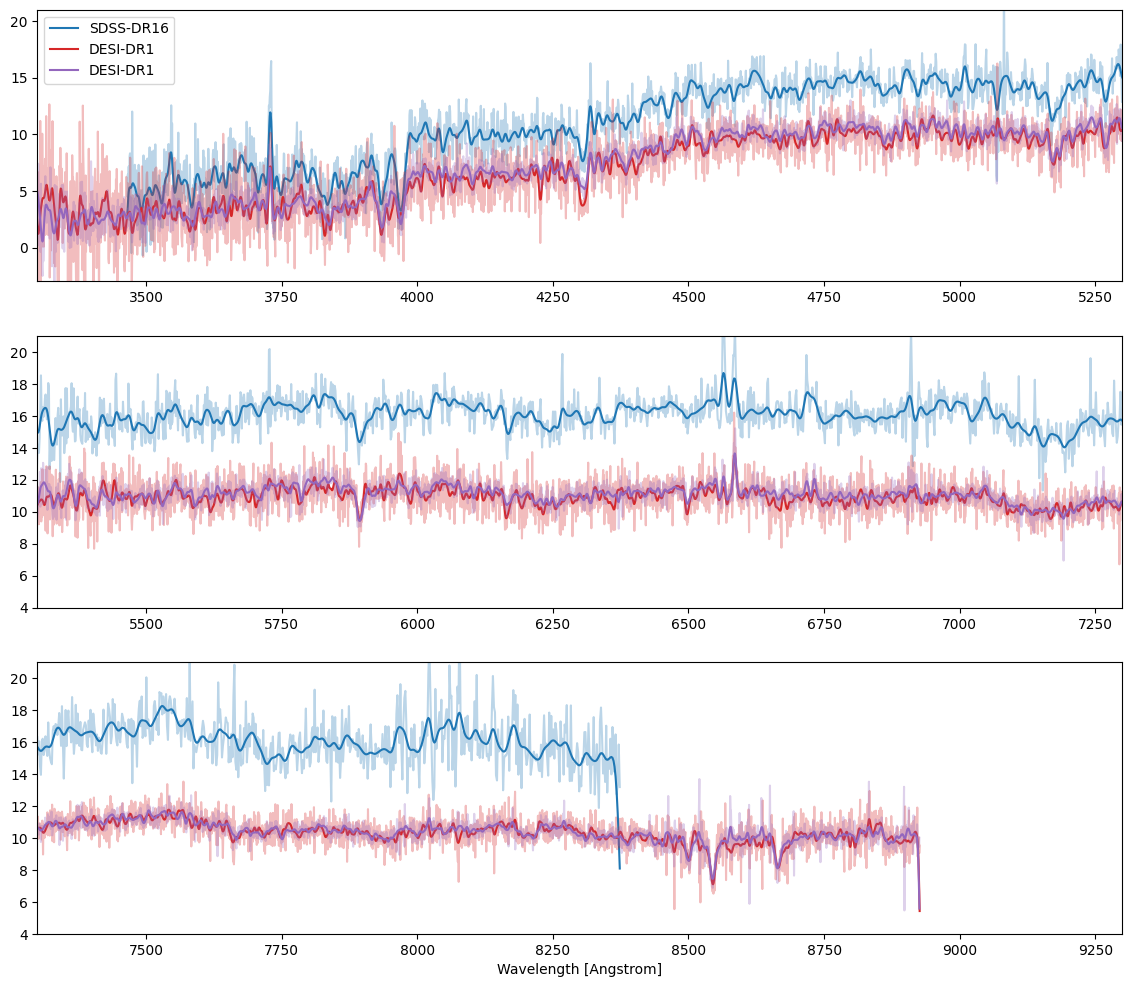

In [30]:
# SDSS spectrum with dateobs_center on 2008-02-13
# df_spec['specid']== 3242699284616865792

# First DESI spectrum with dateobs_center on 2022-03-22
# df_spec['specid']==39627908548924068

# Second DESI spectrum with dateobs_center on 2022-05-06
# df_spec['specid']==2842647530045447

specids = [3242699284616865792, 39627908548924068, 2842647530045447]
drs = ['SDSS-DR16', 'DESI-DR1', 'DESI-DR1']
cols = ['tab:blue', 'tab:red', 'tab:purple']

fig, axs = plt.subplots(3, 1, figsize=(14,12))

xlims = [[3300, 5300], [5300, 7300], [7300, 9300]]
ylims = [[-3, 21], [4, 21], [4, 21]]

for i, xlim in enumerate(xlims):
    ax = axs[i]

    for j, specid in enumerate(specids):
        r = (df_spec['specid']==specid)&(df_spec['data_release']==drs[j])
        z = df_spec['redshift'][r].iloc[0]
        ivar = df_spec[r].iloc[0].ivar/(1.+z)**2
        wl = df_spec[r].iloc[0].wavelength/(1.+z)
        flux = df_spec[r].iloc[0].flux*(1.+z)
        valid = ivar!=0.
        
        ax.plot(wl[valid], flux[valid], alpha=0.3, color=cols[j])
        ax.plot(wl[valid], convolve(flux[valid], Gaussian1DKernel(3)), color=cols[j], label=drs[j])

#    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylims[i])

# For top panel, add legend
axs[0].legend()

# For the bottom panel, add axis label
axs[2].set_xlabel('Wavelength [Angstrom]');

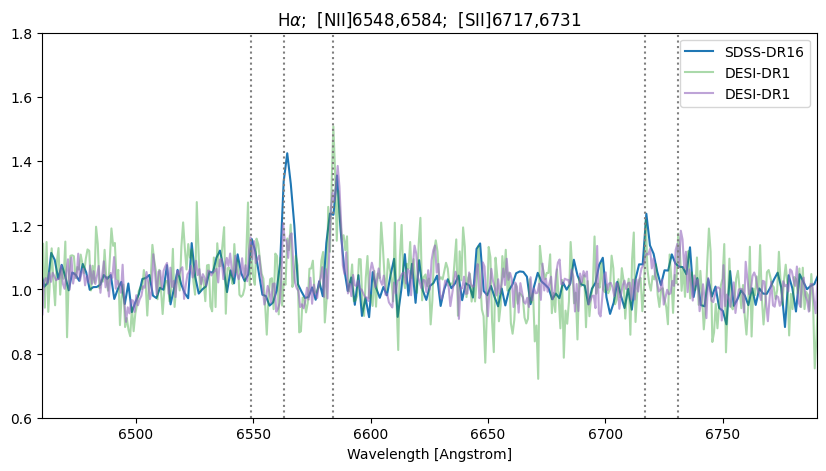

In [31]:
# Zooming in around H-alpha + normalizing spectra for better comparison
fig, ax = plt.subplots(1, 1, figsize=(10,5))

cols = ['tab:blue', 'tab:green', 'tab:purple']

# Will plot darker color for SDSS (in the back) compared to DESI
alphas = [1, 0.4, 0.6]

for j, specid in enumerate(specids):
    r = (df_spec['specid']==specid)&(df_spec['data_release']==drs[j])
    z = df_spec['redshift'][r].iloc[0]
    ivar = df_spec[r].iloc[0].ivar/(1.+z)**2
    wl = df_spec[r].iloc[0].wavelength/(1.+z)
    flux = df_spec[r].iloc[0].flux*(1.+z)
    valid = ivar!=0.
    
    # will normalize by median over wl range w/o strong features
    rnorm = (wl>6800)&(wl<=6900)
    norm = np.median(flux[rnorm])

    # plot normalized spectrum
    ax.plot(wl[valid], flux[valid]/norm, alpha=alphas[j], color=cols[j], label=drs[j])

lines = [6549, 6563, 6584, 6717, 6731]
for line in lines:
    ax.axvline(line, ls=':', color='grey')

ax.legend()
ax.set_xlim(6460, 6790)
ax.set_ylim(0.6, 1.8)

# add axis label and text
ax.set_xlabel('Wavelength [Angstrom]')
ax.set_title('H$\\alpha$;  [NII]6548,6584;  [SII]6717,6731');


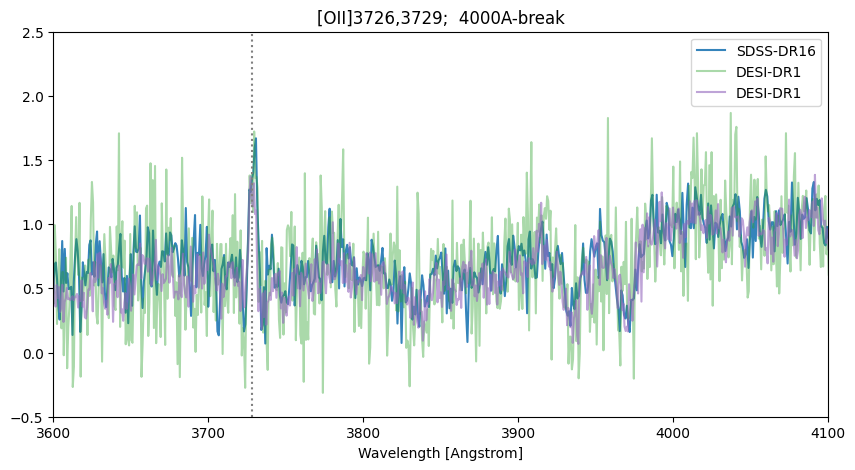

In [32]:
# Zooming in around [OII] and D4000 + normalizing spectra for better comparison
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# Will plot darker color for SDSS (in the back) compared to DESI
alphas = [0.9, 0.4, 0.6]

for j, specid in enumerate(specids):
    r = (df_spec['specid']==specid)&(df_spec['data_release']==drs[j])
    z = df_spec['redshift'][r].iloc[0]
    ivar = df_spec[r].iloc[0].ivar/(1.+z)**2
    wl = df_spec[r].iloc[0].wavelength/(1.+z)
    flux = df_spec[r].iloc[0].flux*(1.+z)
    valid = ivar!=0.
    
    # will normalize by median over wl range w/o strong features
    rnorm = (wl>4100)&(wl<=4150)
    norm = np.median(flux[rnorm])

    # plot normalized spectrum
    ax.plot(wl[valid], flux[valid]/norm, alpha=alphas[j], color=cols[j], label=drs[j])

# [OII] doublet
ax.axvline(3728, ls=':', color='grey')

ax.legend()
ax.set_xlim(3600, 4100)
ax.set_ylim(-0.5, 2.5)

# add axis label and text
ax.set_xlabel('Wavelength [Angstrom]')
ax.set_title('[OII]3726,3729;  4000A-break');

<a class="anchor" id="morphology"></a>
## BONUS: Large-Scale Structures with LS Morphologies

In this section, we will leverage the photometry from the DESI pre-imaging Legacy Survey (LS). The advantage of the LS photometry is that it reaches deeper than SDSS by about 1 magnitude, which yields better image quality to measure magnitudes, colors, and galaxy shapes. 

We will start with the object "TYPE" from LS, related to the morphological shapes. 

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for [LS DR10 Morphological Classification](https://www.legacysurvey.org/dr10/description/#morphological-classification):
<ul>
<li>PSF (point spread function: size will vary with the seeing of the observations)</li>
<li>REX (“round exponential” galaxies with a variable effective radius)</li>
<li>EXP (exponential profile; spiral galaxies)</li>
<li>DEV (deVaucouleurs profile; elliptical galaxies)</li>
<li>SER (Sersic profile)</li>
<li>DUP (set for Gaia sources duplicated by an extended source -- for information only, no flux)</li>
</ul>

<figure>
<img src="Gals_Qso.jpg", align="left", width=600>
<figcaption> Figure: Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

### Joint query to SDSS DR17 & LS DR10

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as other quantities. 

The Legacy Survey DR10 database is called **ls_dr10** and includes several tables. We will use the **tractor** table together with the positional crossmatched table with specObj table from SDSS/BOSS DR17. 

The SDSS DR17 database is called **sdss_dr17** and also includes several tables. We will use the **specobj** table, which has spectroscopic information.

We will use a pre-crossmatched table based on the closest match within a 1.5 arcsec search radius.

The columns from the LS table used (Tractor) can be seen here: https://datalab.noirlab.edu/query.php?name=ls_dr10.tractor

The columns from the pre-crossmatched table can be seen here: https://datalab.noirlab.edu/query.php?name=ls_dr10.x1p5__tractor__sdss_dr17__specobj

**Note:** The column names and descriptions can also be found directly in a notebook with `qc.schema()` or by using the Table Access Protocol (TAP) service with a compatible tool such as TOPCAT.

In [33]:
# Define a region of interest: RA, Dec in degrees
ra_min = 183.5
ra_max = 187.
dec_min = 3.7
dec_max = 6.2

In [34]:
# ls_dr10.tractor                            # LS DR10 tractor photometry
# ls_dr10.x1p5__tractor__sdss_dr17__specobj  # LS DR10 pre-crossmatched to SDSS DR17 specobj
# sdss_dr17.specobj                          # SDSS DR17 specobj

# Write query statement (sql)
query = ("""
  SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z, L.flux_r, L.flux_z, 
         S.specobjid as specobjid_dr17, S.z, S.ra as plug_ra, S.dec as plug_dec, S.class 
  FROM sdss_dr17.specobj AS S 
  JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON S.specobjid=X.id2
  JOIN ls_dr10.tractor AS L ON X.id1=L.ls_id
  WHERE S.z>0.001 AND S.ra BETWEEN %s AND %s AND S.dec BETWEEN %s AND %s  
  LIMIT 100000
  """) % (ra_min, ra_max, dec_min, dec_max)  # small region

# L.ra, L.dec        = RA, Dec from Legacy Survey (LS) table    
# L.type             = object type (PSF, SIMP, EXP, DEV, COMP)
# L.g_r, L.r_z       = pre-computed g-r and r-z colors from photometry
# S.z                = redshift (z) from SDSS specObj table
# S.plug_ra, dec     = RA, Dec of SDSS fiber from specObj table
# S.class            = Source class (Star, Galaxy, QSO) from SDSS
#
# WHERE: requirement that RA & Dec coordinates are within a rectangular region
#        and extragalactic sources with z>0.001 cut

print(query)


  SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z, L.flux_r, L.flux_z, 
         S.specobjid as specobjid_dr17, S.z, S.ra as plug_ra, S.dec as plug_dec, S.class 
  FROM sdss_dr17.specobj AS S 
  JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON S.specobjid=X.id2
  JOIN ls_dr10.tractor AS L ON X.id1=L.ls_id
  WHERE S.z>0.001 AND S.ra BETWEEN 183.5 AND 187.0 AND S.dec BETWEEN 3.7 AND 6.2  
  LIMIT 100000
  


In [35]:
# Call query client and save output as Astropy Table
result = qc.query(sql=query, fmt='table')

### Query DESI DR1 for same region of the sky

In [36]:
# Write query statement (sql)
query_desi = (f"""
  SELECT Z.targetid, Z.mean_fiber_ra AS ra, Z.mean_fiber_dec AS dec, Z.spectype, Z.z, Z.zwarn, 
         P.morphtype, P.sersic, P.flux_r, P.flux_z
  FROM desi_dr1.zpix as Z
  LEFT JOIN desi_dr1.photometry as P
  ON Z.targetid = P.targetid
  WHERE z>0.001 AND mean_fiber_ra BETWEEN {ra_min} AND {ra_max} AND mean_fiber_dec BETWEEN {dec_min} AND {dec_max}  
  LIMIT 100000""")

print(query_desi)


  SELECT Z.targetid, Z.mean_fiber_ra AS ra, Z.mean_fiber_dec AS dec, Z.spectype, Z.z, Z.zwarn, 
         P.morphtype, P.sersic, P.flux_r, P.flux_z
  FROM desi_dr1.zpix as Z
  LEFT JOIN desi_dr1.photometry as P
  ON Z.targetid = P.targetid
  WHERE z>0.001 AND mean_fiber_ra BETWEEN 183.5 AND 187.0 AND mean_fiber_dec BETWEEN 3.7 AND 6.2  
  LIMIT 100000


In [37]:
# Call query client and save output as Astropy Table
result_desi = qc.query(sql=query_desi, fmt='table')

In [38]:
# Select redshift slice near peak at z~0.1
zmin = 0.097
zmax = 0.105

# Redshift range
rz = (result['z'] >zmin) & (result['z']<zmax)
rz_desi = (result_desi['z'] >zmin) & (result_desi['z']<zmax)

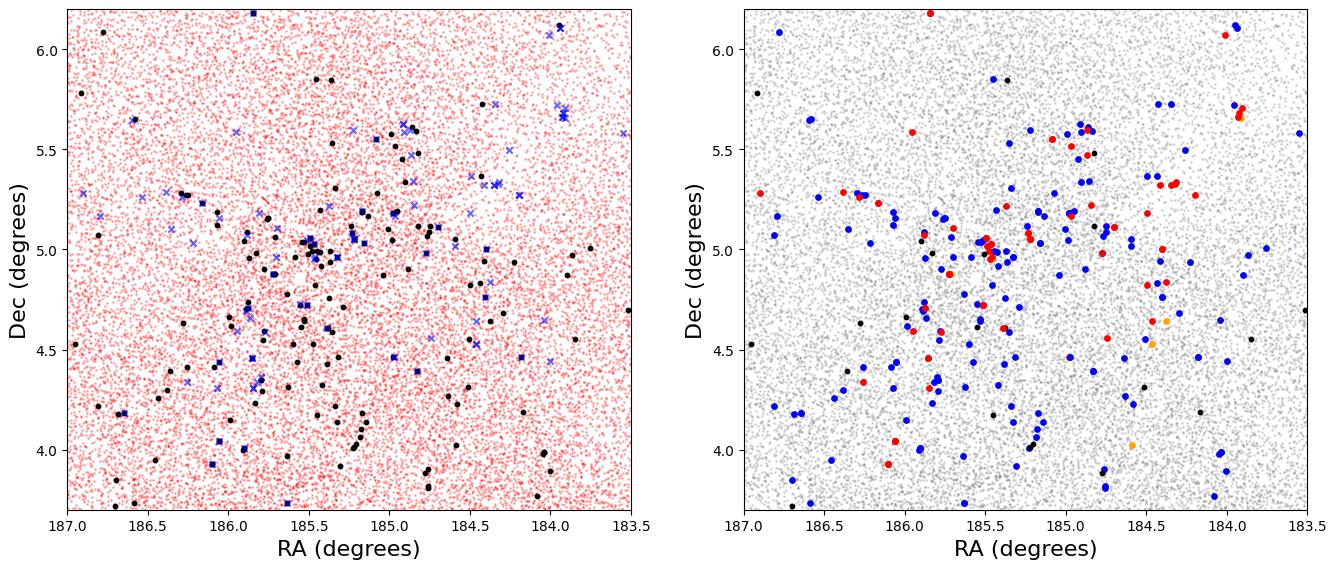

In [39]:
# Extent of RA, Dec (in degrees) to plot
xmin = ra_min
xmax = ra_max
ymin = dec_min
ymax = dec_max

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6.5))

# DESI
ra = result_desi['ra']
dec = result_desi['dec']
rz_plot = rz_desi
morphtype = result_desi['morphtype']
sersic = result_desi['sersic']

# plot all points in red (all redshifts)
ax1.scatter(ra, dec, s=1, color='r', marker='o', alpha=0.25)

# overplot in black objects in narrow redshift slice
ax1.scatter(ra[rz_plot], dec[rz_plot], s=10, color='black')

# Add SDSS locations in the same redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=20,color='b',marker='x', alpha=0.6, label='SDSS')

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=16)
ax1.set_ylabel("Dec (degrees)", fontsize=16)


# Second panel: plot all points in gray (all redshifts)
ax2.scatter(ra, dec, s=1, color='gray', marker='o', alpha=0.25)

# Select redshift slice and per morphological type

# DEV or early type Sersic with steep index Sersic>=3
rdev = ((morphtype=='DEV')|((morphtype=='SER')&(sersic>=3))) & rz_plot
# EXP or late type Sersic with index Sersic<2
rexp = ((morphtype=='EXP')|(morphtype=='REX')|((morphtype=='SER')&(sersic<2))) & rz_plot
# Intermediate with 2<= Sersic < 3
rint = ((morphtype=='SER')&(sersic>=2)&(sersic<3)) & rz_plot
# PSF is for point source shape, which we expect for stars but possibly quasars or distant, unresolved galaxies
rpsf = (morphtype=='PSF')&rz_plot

# overplot in objects in narrow redshift slice color-coded blue (EXP or Late type) or red (DEV or Early type)
ax2.scatter(ra[rexp], dec[rexp], s=15, color='b')         # blue = EXP or late-type Sersic
ax2.scatter(ra[rint], dec[rint], s=15, color='orange')    # orange = Intermediate
ax2.scatter(ra[rdev], dec[rdev], s=15, color='r')         # red = DEV or early-type Sersic
ax2.scatter(ra[rpsf], dec[rpsf], s=10, color='k')         # red = DEV or early-type Sersic

# Add SDSS
ra = result['plug_ra']
dec = result['plug_dec']
rz_plot = rz
morphtype = result['type']
sersic = result['sersic']

# Select redshift slice and per morphological type

# DEV or early type Sersic with steep index Sersic>=3
rdev = np.where(((morphtype=='DEV')|((morphtype=='SER')&(sersic>=3))) & rz_plot)
# EXP or late type Sersic with index Sersic<2
rexp = np.where(((morphtype=='EXP')|(morphtype=='REX')|((morphtype=='SER')&(sersic<2))) & rz_plot)
# Intermediate with 2<= Sersic < 3
rint = np.where(((morphtype=='SER')&(sersic>=2)&(sersic<3)) & rz_plot)

# overplot in objects in narrow redshift slice color-coded blue (EXP or Late type) or red (DEV or Early type)
ax2.scatter(ra[rexp], dec[rexp], s=15, color='b')         # blue = EXP or late-type Sersic
ax2.scatter(ra[rint], dec[rint], s=15, color='orange')    # orange = Intermediate
ax2.scatter(ra[rdev], dec[rdev], s=15, color='r')         # red = DEV or early-type Sersic

plt.axis([xmin, xmax, ymin, ymax])
plt.xlim(reversed(plt.xlim())) # flip the x-axis
plt.xlabel("RA (degrees)", fontsize=16)
plt.ylabel("Dec (degrees)", fontsize=16)
plt.show()

<a class="anchor" id="exercise"></a>
## EXERCISE: Large-Scale Structures with Galaxy Colors

There are many possible extensions to this work. For instance, one could plot again with symbols coded with spectral type (*class* from SDSS; *spectype* from DESI) and/or velocity dispersion (from SDSS) and/or other quantities such as photometric colors.

There are pre-computed colors available. The columns are described here:
https://datalab.noirlab.edu/query.php?name=ls_dr10.tractor

Exercise: plot again the galaxies spatial coordinates, but color-coded according to their photometric colors. This is left as an exercise for the user, but feel free to get in touch with the Astro Data Lab Team if you have questions.

<a class="anchor" id="references"></a>
# To learn more

Section with important references and link to other notebooks of interest!!!!!

**Notebooks**
- How to use DESI DR1
- DESI vs. SDSS comparison
- How to use SPARCL:
    - `notebooks-latest/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb`
    - [on GitHub](url)
- ?

**Data Acknowledgments**
- SDSS
- DESI